In [1]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr

import numpy as np
import pandas as pd
# from pandas import Series
# from scipy.stats import gamma, norm, fisk, genextreme
# from numpy import linspace, std
import plotly.graph_objects as go
# import geopandas as gpd
import os
import pickle
import joblib

In [2]:
# Suivant le secteur sur lequel on veut travailler
    # 79_sevre_nantaise
    # 26_drome
zone = '79_sevre_nantaise' # < Valeur à changer
futur = True # Pour voir les valeurs futurs ou voir les performances du modèles sur valeurs passées

In [3]:
# Chargement des données
d = {}
for filename in os.listdir('./zones/'+zone+'/'):
    if filename.endswith('.parquet'):
        key = filename[:-8]
        d[int(key)] = pd.read_parquet('./zones/'+zone+'/'+filename)
summary = []
with open('./zones/'+zone+'/summary_zones.pickle', 'rb') as fp:
    summary = pickle.load(fp)

In [4]:
# chargement des données futurs (modèle)
t = {}
for filename in os.listdir('./79_sevre_nantaise_spei_futur/'):
    if filename.endswith('.parquet'):
        key = filename[11:-8]
        t[key] = pd.read_parquet('./79_sevre_nantaise_spei_futur/'+filename)

In [5]:
t.keys()
X_test_futur = t['IPSL_rcp85'].loc['1985':'2099'].drop(["Events", "wb"], axis=1)
X_test_futur.head(3)

,pr,et0,spei3,spei6,spei12,spei24,spei48
date,,,,,,,
1985-01-01,0.002037,-0.000809,0.576442,1.005744,0.683485,1.397189,1.629214
1985-02-01,0.002255,-0.001388,-0.721240,0.784038,0.746315,1.304469,1.616932
1985-03-01,0.003016,-0.001941,0.310252,0.815119,0.821529,1.336294,1.578625


In [6]:
# Création d'une table de synthèse
df_summary = pd.DataFrame(summary, columns=['id', 'zone', 'tp_mean', 'pe_mean', 'wb_mean'])
df_summary.set_index('id', inplace=True)
df_summary

,zone,tp_mean,pe_mean,wb_mean
id,,,,
3747,54_79_12,0.002207,-0.004459,-0.002252
6299,54_79_12,0.002207,-0.004459,-0.002252
6938,54_79_12,0.002207,-0.004459,-0.002252


In [7]:
# A activer si on voulait ajouter/créer des variables explicatives supplémentaires (features engineering)
# Par exemple une valeur de changement realtif de cahque spei sur une période de 3 mois (pour prendre en compte la dynamique de la série de spei, pas seulement la valeur au mois m)
mspei = [3,6,12,24]
for df in d:
    for scale in mspei:
        varname = 'spei'+str(scale)
        d[df][varname+'_d1'] = (d[df][varname] - d[df][varname].shift(1)) 
        d[df][varname+'_d2'] = (d[df][varname] - d[df][varname].shift(2)) 
        d[df][varname+'_d3'] = (d[df][varname] - d[df][varname].shift(3)) 

#shift_month = [1,2,3,4,5,6,7,8,,9,10,11,12]
#/ d[df][varname]

In [8]:
# Récupère toutes les informations de spei pour les id_zones sélectionnées
dfs_select = [d[name] for name in d]
df = pd.concat(dfs_select)

In [9]:
# Absence de restriction	0.0
# Vigilance	1.0
# Modification du régime hydraulique	2.0
# Alerte	3.0
# Alerte renforcée	4.0
# Crise modérée	4.0
# Crise	5.0
# Crise renforcée	6.0
# Arrêt des prélèvements non prioritaires	7.0

In [10]:
# En première approche on conserve pour ces zones le statut max d'arrêté de chaque mois (on voit que chaque id_zone couvre souvent une portion de la série temporelle, mais que c'est le même territoire qui est évalué)
df = df.groupby('time').max()

<Axes: xlabel='time'>

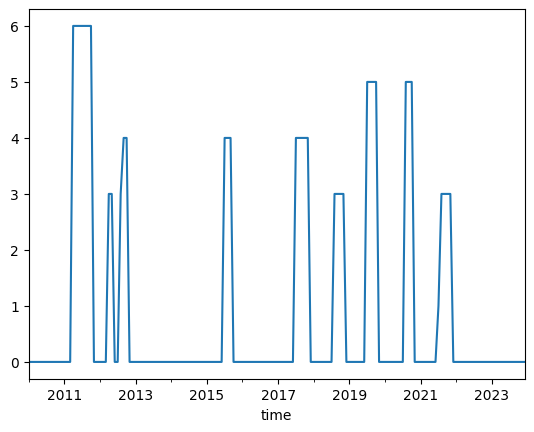

In [11]:
# Visualisation des événements conservés dans les différentes zones
df['Events'].loc['2010':'2023'].plot()

In [12]:
# Définition des périodes sur lequels on va faire l'entrainelment du modèle et celles où on va tester
start_train = '2010'
end_train = '2016'
start_test = '2017'
end_test = '2023'



In [13]:
# Tri et visualisation des données utilisées dans le modèle
df = df.loc['2000':]
df.sort_index(inplace=True)
df

,tp,pev,wb,Events,spei3,spei6,spei12,spei24,spei48,spei3_d1,...,spei3_d3,spei6_d1,spei6_d2,spei6_d3,spei12_d1,spei12_d2,spei12_d3,spei24_d1,spei24_d2,spei24_d3
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.000644,-0.001188,-0.000545,0.0,0.044770,1.490717,1.424778,0.800836,-0.199499,-0.887090,...,-1.720477,-0.119721,0.294619,0.160677,-0.046995,0.148175,0.299616,-0.176223,-0.103759,-0.185009
2000-02-01,0.002401,-0.001802,0.000599,0.0,0.382339,1.178146,1.435321,0.963329,-0.210207,0.337568,...,-1.006026,-0.312571,-0.432292,-0.017952,0.010543,-0.036451,0.158718,0.162493,-0.013729,0.058735
2000-03-01,0.001341,-0.003938,-0.002597,0.0,-0.837804,0.213287,1.309922,1.014618,-0.210461,-1.220143,...,-1.769665,-0.964859,-1.277430,-1.397151,-0.125399,-0.114856,-0.161851,0.051289,0.213783,0.037560
2000-04-01,0.004019,-0.004526,-0.000507,0.0,0.654884,0.614958,1.315365,0.738421,0.045455,1.492688,...,0.610114,0.401671,-0.563188,-0.875759,0.005443,-0.119957,-0.109413,-0.276197,-0.224908,-0.062415
2000-05-01,0.002027,-0.005545,-0.003517,0.0,0.407308,0.555922,1.083179,0.921239,0.017482,-0.247577,...,0.024969,-0.059036,0.342636,-0.622224,-0.232186,-0.226743,-0.352142,0.182818,-0.093380,-0.042090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.000622,-0.003464,-0.002841,0.0,1.783986,1.736717,1.350324,-0.548045,-0.629131,0.445488,...,0.747404,0.397651,0.823037,1.234733,0.699017,1.777445,2.015088,0.320209,0.602618,0.512441
2023-09-01,0.001552,-0.003076,-0.001524,0.0,1.923875,1.850616,1.504672,-0.329676,-0.366059,0.139889,...,0.815725,0.113898,0.511550,0.936935,0.154348,0.853365,1.931793,0.218369,0.538578,0.820987
2023-10-01,0.002166,-0.002114,0.000051,0.0,1.700936,1.792359,1.604708,-0.233287,-0.421692,-0.222938,...,0.362438,-0.058256,0.055642,0.453293,0.100037,0.254384,0.953402,0.096389,0.314758,0.634967


In [14]:
df['summer_month'] = df.index.month.isin([8, 9, 10]).astype(int)

# Créer une colonne "year" qui s'incrémente chaque année
df['year'] = df.index.year - df.index.year.min() + 1

In [15]:
df['megabassines'] = 0
df.loc['2022-06-01':'2023-12-01', 'megabassines'] = 1

In [16]:
je_veux_merge = False
if je_veux_merge == True:
    df_water = pd.read_excel('Water_supply-demand.xlsx', sheet_name="tout_climato")
    dfw = df_water
    #dfw = dfw.rename(columns=dfw.iloc[0]).drop(dfw.index[0])
    dfw = dfw.iloc[:,:5]
    dfw['time'] = pd.to_datetime(dfw['time'])
    dfw['time'] = dfw['time'].apply(lambda x: x.replace(day=1))
    df = df.reset_index()
    df['time'] = df['time'].apply(lambda x: x.replace(day=1))

    merged_df = pd.merge(dfw, df, on='time', how='inner')

    print(df.shape)
    print(dfw.shape)
    print(merged_df.shape)

    merged_df.set_index('time', inplace=True)

    print("Attention!!",merged_df.shape)
    df = merged_df

In [17]:
# Liste des variables explicatives sélectionnées pour la modélisation

if futur:
    lfeat = np.r_[0:2, 4:9]
else:
    lfeat = np.r_[0:2, 4:len(df.columns)]
    
df.columns[lfeat]

Index(['tp', 'pev', 'spei3', 'spei6', 'spei12', 'spei24', 'spei48'], dtype='object')

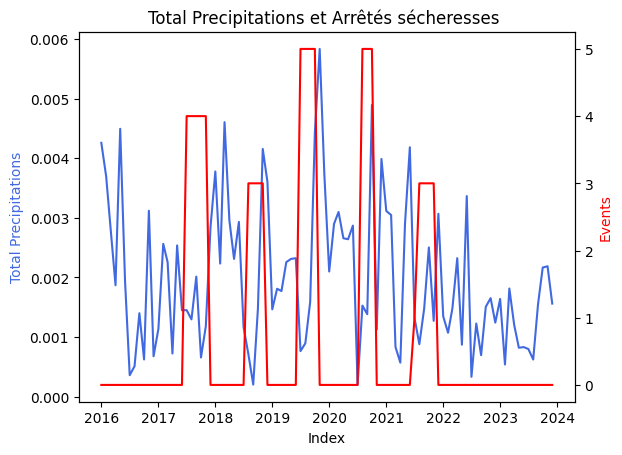

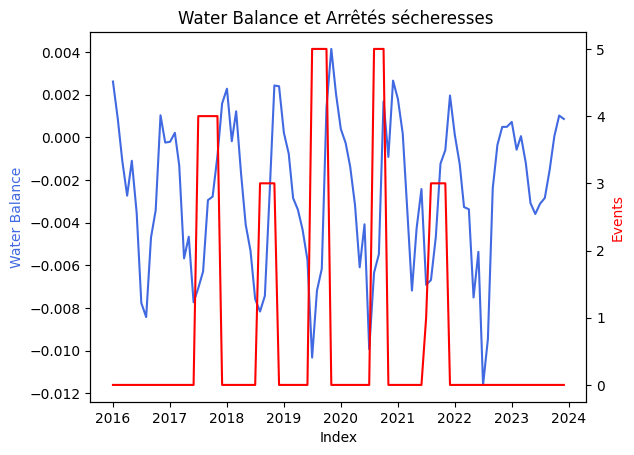

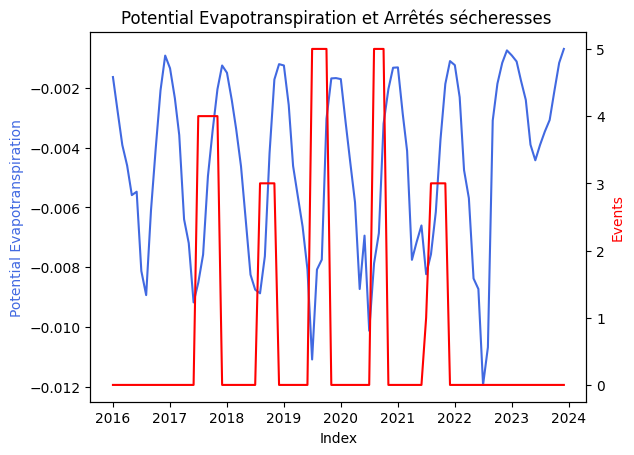

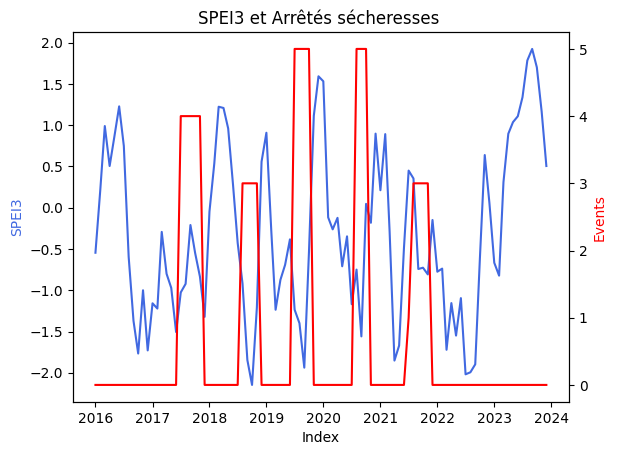

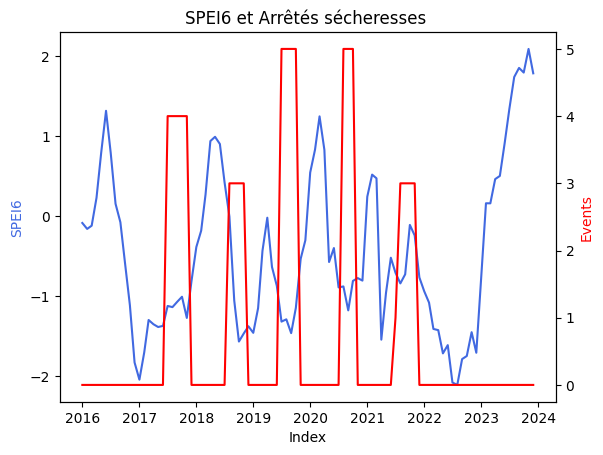

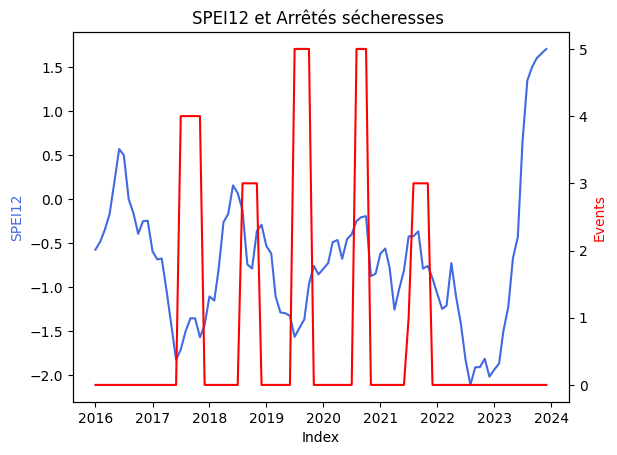

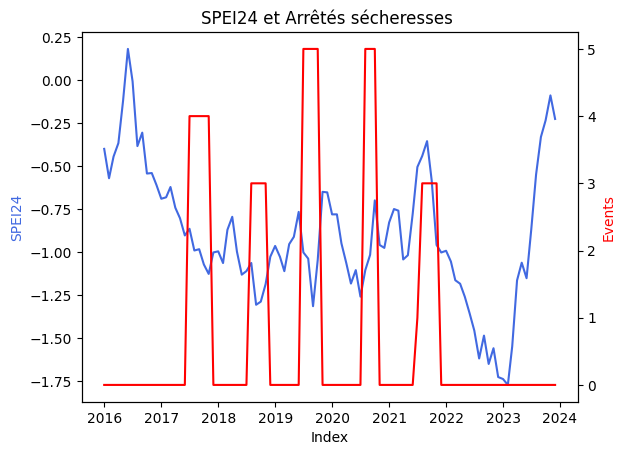

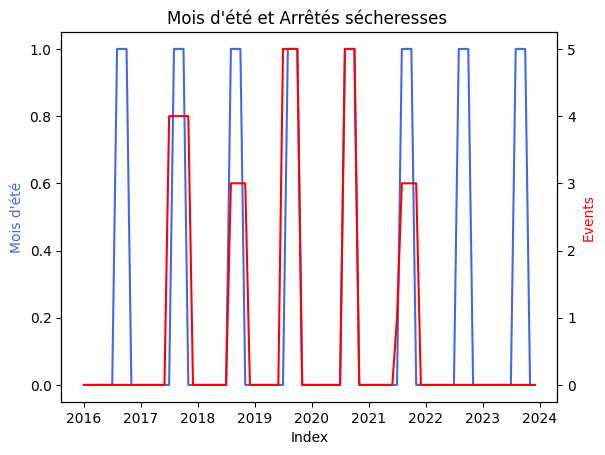

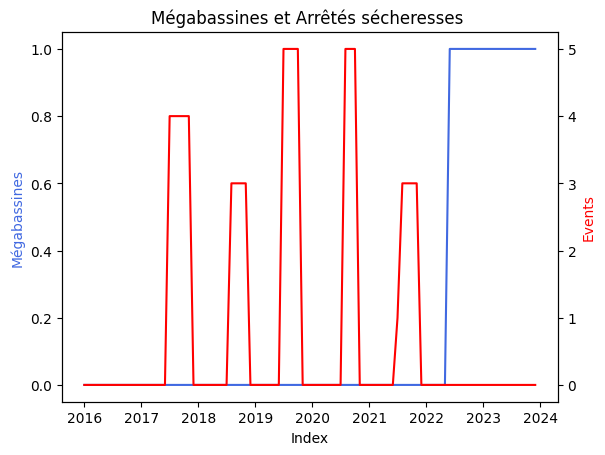

In [18]:

import matplotlib.pyplot as plt

def plot_with(var, title):
    # Assuming your DataFrame is called df
    column1 = df.loc['2016':'2024'][var]
    column2 = df.loc['2016':'2024']['Events']

    #column1 = df.loc['2010':'2014'][var]
    #column2 = df.loc['2010':'2014']['Events']

    # Create a figure and two subplots
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Plot column1 on ax1
    ax1.plot(column1, color='royalblue')
    ax1.set_ylabel(title, color='royalblue')

    # Plot column2 on ax2
    ax2.plot(column2, color='red')
    ax2.set_ylabel('Events', color='red')

    # Set labels and title
    ax1.set_xlabel('Index')
    plt.title(title+' et Arrêtés sécheresses ')

    # Show the plot
    plt.show()

for var in ['tp', 'wb', 'pev', 'spei3', 'spei6', 'spei12', 'spei24', 'summer_month', 'megabassines', 'demand_data']:
    try:
        title = {'tp':'Total Precipitations', 'wb' : 'Water Balance', 'pev':'Potential Evapotranspiration', 'spei3':'SPEI3', 'spei6':'SPEI6', 'spei12':'SPEI12', 'spei24':'SPEI24', 'summer_month':"Mois d'été", 'megabassines':"Mégabassines", 'demand_data':'Demande'}[var]
        plot_with(var, title)
    except:
        pass

In [19]:
# Création de la matrice de variables explicatives
X =  df.iloc[:, lfeat].to_numpy()
X.shape

(288, 7)

In [20]:
# Création de la série des événements à prévoir. En première approche on travaille sur une vision binaire. 0 si "Absence de restriction" ; 1 dans toues les autres cas (quelquesoit le niveau d'alerte/crise)
y = np.multiply((df['Events']>=1),1).to_numpy()
y.shape

(288,)

In [21]:
# Modèle de Machine Learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# On fixe une seed pour la reproductibilité
seed = 42

# Gestion des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Gestion des indices
indices = np.arange(X_imputed.shape[0])

# Gestion de la standardisation des variables explicatives
scaler = StandardScaler()
X_imputed = scaler.fit_transform(X_imputed)

# Dans le cas où on voudrait splitter la série en 2 aléatoirement
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
#     X_imputed, y, indices, test_size=0.25, random_state=seed)

# Split des données dans le cas où on veut entrainer sur la première partie historique et tester sur la deuxième partie (souhaitable dazns notre contexte car on veut évaluer le pouvoir prédictif du modèle dans un contexte de changement climatique et donc commenter la transposabilité temporelle du modèle)
X_train = X_imputed[(df.index.year >= int(start_train)) & (df.index.year <= int(end_train))]
X_test = X_imputed[(df.index.year >= int(start_test)) & (df.index.year <= int(end_test))]
y_train = y[(df.index.year >= int(start_train)) & (df.index.year <= int(end_train))]
y_test = y[(df.index.year >= int(start_test)) & (df.index.year <= int(end_test))]
indices_train = indices[(df.index.year >= int(start_train)) & (df.index.year <= int(end_train))]
indices_test = indices[(df.index.year >= int(start_test)) & (df.index.year <= int(end_test))]

# Gestion de indices d'entrainement et de test
dates_train = df.iloc[indices_train].index
dates_test = df.iloc[indices_test].index

In [22]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
# Création et entrainement d'un modèle simple de Random Forest
from sklearn.svm import SVC

#classifier = RandomForestClassifier(n_estimators=1000, max_depth=20, criterion='entropy', random_state=seed, n_jobs=8, verbose=False)
classifier = SVC(probability=True)
classifier.fit(X_train, y_train)

SVC(probability=True)

In [24]:
# A activer si veut sauvegarder le modèle courant
# joblib.dump(classifier, "../RFC_cluster_all.joblib")

In [25]:
# A activer si veut charger un modèle existant, plutôt que dans créer/entrainer un nouveau
# classifier = joblib.load("../RFC_cluster_all.joblib")
# classifier.fit(X_train, y_train)

In [26]:
# Création des informations/résultats d'entrainement
df_train = pd.DataFrame(y_train, columns=['y_train'])
df_train['y_eval'] = classifier.predict(X_train)
df_train['y_eval_proba'] = classifier.predict_proba(X_train)[:, 1]  # Probabilité d'avoir un "événement" (arrêté)
df_train.index = dates_train
df_train.sort_index(inplace=True)

In [27]:
time_futur = X_test_futur.index
X_futur_transformed = imputer.fit_transform(X_test_futur.to_numpy())
df_proba_futur = classifier.predict_proba(X_futur_transformed)[:, 1]

fig = go.Figure()

fig.add_trace(go.Scatter(x=time_futur, y=df_proba_futur, mode='markers', name='Predicted Probability', marker=dict(symbol='diamond-open')))
fig.update_layout(title='Time Series of Observed vs. Evaluated',
                  xaxis_title='Time',
                  yaxis_title='Outcome',
                legend=dict(
                    x=0.5,
                    y=-0.3,
                    orientation='h',
                    xanchor='center',
                    yanchor='top'
    )
                 ,
                 height=500)
fig.show()

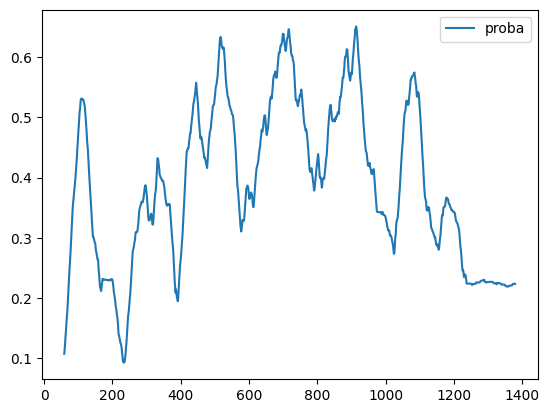

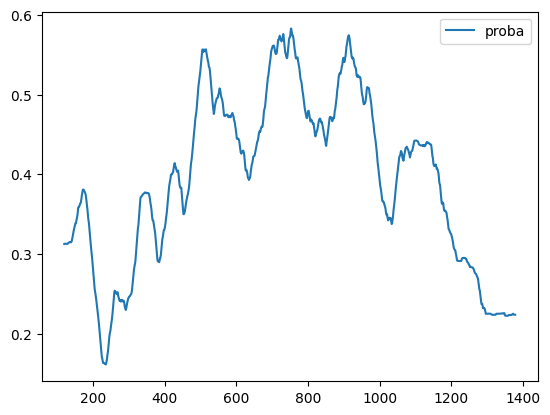

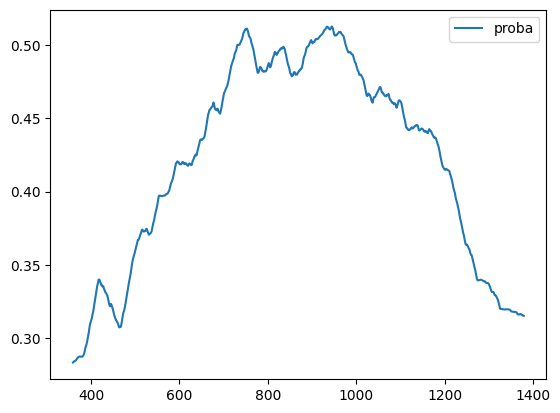

In [28]:
time_futur
df_proba_futur
proba_futur_pr_mean = pd.DataFrame({'time':time_futur,'proba':list(df_proba_futur)})
l_nb_years = [5,10,30]
for nb_years in l_nb_years:
    moyenne_glissante = proba_futur_pr_mean['proba'].rolling(window=12*nb_years).mean()
    pd.DataFrame(moyenne_glissante).plot()

In [29]:
# Création des informations/résultats de test
df_pred = pd.DataFrame(y_test, columns=['y_test'])
df_pred['y_pred'] = classifier.predict(X_test)
df_pred['y_pred_proba'] = classifier.predict_proba(X_test)[:, 1]  # Probabilité d'avoir un "événement" (arrêté)
df_pred.index = dates_test
df_pred.sort_index(inplace=True)

In [30]:
# Graphique de visualisation des résultats sur la période d'entrainement
time = df_train.index
actual = df_train['y_train']
predicted = df_train['y_eval']
probabilities = df_train['y_eval_proba']

# Time Series of Actual vs. Predicted
fig = go.Figure()
# lines+markers
fig.add_trace(go.Scatter(x=time, y=actual, mode='markers', name='Actual', line=dict(width=2)))
fig.add_trace(go.Scatter(x=time, y=predicted, mode='markers', name='Predicted', marker=dict(symbol='circle-open-dot'), line=dict(width=1, dash='dot')))
fig.add_trace(go.Scatter(x=time, y=probabilities, mode='markers', name='Predicted Probability', marker=dict(symbol='diamond-open')))
fig.update_layout(title='Time Series of Observed vs. Evaluated',
                  xaxis_title='Time',
                  yaxis_title='Outcome',
                legend=dict(
                    x=0.5,
                    y=-0.3,
                    orientation='h',
                    xanchor='center',
                    yanchor='top'
    )
                 ,
                 height=500)
fig.show()

In [31]:
# Graphique de visualisation des résultats sur la période de test
time = df_pred.index
actual = df_pred['y_test']
predicted = df_pred['y_pred']
probabilities = df_pred['y_pred_proba']

# Time Series of Actual vs. Predicted
fig = go.Figure()
# lines+markers
fig.add_trace(go.Scatter(x=time, y=actual, mode='markers', name='Actual', line=dict(width=2)))
fig.add_trace(go.Scatter(x=time, y=predicted, mode='markers', name='Predicted', marker=dict(symbol='circle-open-dot'), line=dict(width=1, dash='dot')))
fig.add_trace(go.Scatter(x=time, y=probabilities, mode='markers', name='Predicted Probability', marker=dict(symbol='diamond-open')))
fig.update_layout(title='Time Series of Actual vs. Predicted',
                  xaxis_title='Time',
                  yaxis_title='Outcome',
                legend=dict(
                    x=0.5,
                    y=-0.3,
                    orientation='h',
                    xanchor='center',
                    yanchor='top'
    )
                 ,
                 height=500)
fig.show()

<Axes: xlabel='time'>

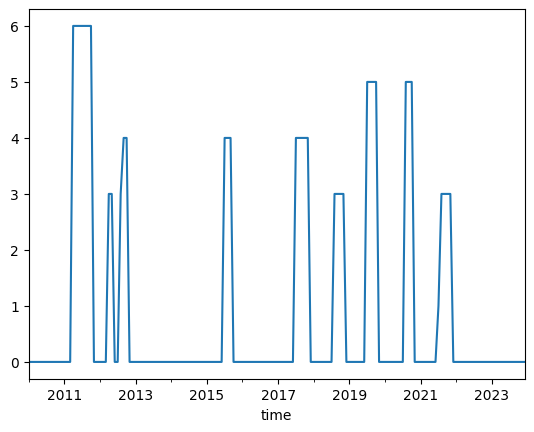

In [32]:
df.Events.loc['2010':'2023'].plot()

In [33]:
# Matrices de confusion sur les périodes d'entrainement et de test
cm_train = confusion_matrix(df_train['y_train'], df_train['y_eval'])
z_text_train = [[str(y) for y in x] for x in cm_train]  # Convert numbers to string for annotations
fig_cm_train = go.Figure(data=go.Heatmap(z=cm_train, x=['Predicted: No', 'Predicted: Yes'], 
                                         y=['Actual: No', 'Actual: Yes'], 
                                         colorscale='Blues', text=z_text_train, texttemplate="%{text}"))
fig_cm_train.update_layout(title='Confusion Matrix - Training', xaxis_title="Predicted Value", 
                           yaxis_title="Actual Value", width=600, height=600)
fig_cm_train.show()

# Confusion Matrix for Testing Data
cm_pred = confusion_matrix(df_pred['y_test'], df_pred['y_pred'])
z_text_pred = [[str(y) for y in x] for x in cm_pred]  # Convert numbers to string for annotations
fig_cm_pred = go.Figure(data=go.Heatmap(z=cm_pred, x=['Predicted: No', 'Predicted: Yes'], 
                                         y=['Actual: No', 'Actual: Yes'], 
                                         colorscale='Blues', text=z_text_pred, texttemplate="%{text}"))
fig_cm_pred.update_layout(title='Confusion Matrix - Testing', xaxis_title="Predicted Value", 
                           yaxis_title="Actual Value", width=600, height=600)
fig_cm_pred.show()

In [34]:
# Courbes ROC sur les périodes d'entrainement et de test

# Compute ROC curve and ROC area - training
fpr1, tpr1, thresholds1 = roc_curve(df_train['y_train'], df_train['y_eval_proba'])
roc_auc1 = roc_auc_score(df_train['y_train'], df_train['y_eval_proba'])

# Plotting ROC curve - training
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=fpr1, y=tpr1, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc1,
                                   line=dict(color='darkorange', width=2)))
fig1.add_shape(type='line', line=dict(dash='dash'),
                        x0=0, x1=1, y0=0, y1=1)
fig1.update_layout(title='Receiver Operating Characteristic (ROC) - Training',
                            xaxis_title='False Positive Rate',
                            yaxis_title='True Positive Rate',
                            legend=dict(x=0.1, y=0.9),
                            autosize=False,
                            width=600,
                            height=600)
fig1.show()

# Compute ROC curve and ROC area - testing
fpr2, tpr2, thresholds2 = roc_curve(df_pred['y_test'], df_pred['y_pred_proba'])
roc_auc2 = roc_auc_score(df_pred['y_test'], df_pred['y_pred_proba'])

# Plotting ROC curve - testing
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=fpr2, y=tpr2, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc2,
                                   line=dict(color='darkorange', width=2)))
fig2.add_shape(type='line', line=dict(dash='dash'),
                        x0=0, x1=1, y0=0, y1=1)
fig2.update_layout(title='Receiver Operating Characteristic (ROC) - Testing',
                            xaxis_title='False Positive Rate',
                            yaxis_title='True Positive Rate',
                            legend=dict(x=0.1, y=0.9),
                            autosize=False,
                            width=600,
                            height=600)
fig2.show()

In [35]:
# Informations complémentaiures sur les périodes d'entrainement et de test

# Confidence of Predictions
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=df_train['y_eval_proba'], name='Train Probabilities'))
fig1.add_trace(go.Histogram(x=df_pred['y_pred_proba'], name='Test Probabilities'))
fig1.update_layout(title='Confidence of Predictions',
                   xaxis_title='Predicted Probability',
                   yaxis_title='Count',
                   barmode='overlay')
fig1.update_traces(opacity=0.75)
fig1.show()

# Feature Importances
try:
    importances = classifier.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    fig2 = go.Figure()
    fig2.add_trace(go.Bar(x=df.iloc[:,lfeat].columns[sorted_indices], y=importances[sorted_indices]))
    fig2.update_layout(title='Feature Importances',
                       xaxis_title='Features',
                       yaxis_title='Importance')
    fig2.show()
except:
    pass

# Overfitting (comparing AUC scores for training and testing sets)
auc_train = roc_auc_score(df_train['y_train'], df_train['y_eval_proba'])
auc_test = roc_auc_score(df_pred['y_test'], df_pred['y_pred_proba'])

fig3 = go.Figure()
fig3.add_trace(go.Bar(x=['Train', 'Test'], y=[auc_train, auc_test]))
fig3.update_layout(title='AUC Scores for Train and Test Sets',
                   xaxis_title='Dataset',
                   yaxis_title='AUC Score')
fig3.show()

In [36]:
# The value for AUC ranges from 0 to 1. A model that has an AUC of 1 is able to perfectly classify observations into classes 
# while a model that has an AUC of 0.5 does no better than a model that performs random guessing.
# 0.5 = No discrimination
# 0.5-0.7 = Poor discrimination
# 0.7-0.8 = Acceptable discrimination
# 0.8-0.9 = Excellent discrimination
# >0.9 = Outstanding discrimination

In [37]:
# Ajouter variable summer_month, year, décalé les spei de 1 mois, 2 mois, 3 mois, 6 mois, 12 mois
# test de plusieurs modèles (Random Forest, SVM, Régression logistique, Réseau de neurones)
# Optimisation des hyperparamètres (GridSearchCV) (sur KNN)
# test de plusieurs variables explicatives (roc, auc et chercher dans mail de grégory)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.metrics import confusion_matrix

models = [
    #LogisticRegression(),    
    #RandomForestClassifier(max_depth= 5, min_samples_leaf=4, min_samples_split=2, n_estimators=10),
    KNeighborsClassifier(n_neighbors=15, p=4, weights='distance'),
    GaussianNB(),   #-> pas mal aussi
    SVC(probability=True), # => Best One sur AUC-ROC et F1 et Accuracy, pas dégueu sur Logloss
    #GradientBoostingClassifier(),
    #MLPClassifier(),
    #AdaBoostClassifier(),
    #DecisionTreeClassifier(),
]

#DecisionTreeClassifier(),

# -- pas assez de données
#GradientBoostingClassifier(),
#MLPClassifier(),
#AdaBoostClassifier(), 

In [39]:
def scores(y_true_input, y_pred_input, y_probs_input):
    
    #y_true = df_pred['y_test']
    #y_pred => meme nom
    #y_probs = y_pred_proba #peut être pas proba

    y_true, y_pred, y_probs = y_true_input, y_pred_input, y_probs_input

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_probs)
    logloss = log_loss(y_true, y_probs)
    mcc = matthews_corrcoef(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("Accuracy:", round(accuracy,3)) 
    #print("Precision:", round(precision,3))
    #print("Recall:", round(recall,3))
    #print("F1-score:", round(f1,3)) # à maximiser ->1 parfait, 0 aléatoire
    print("AUC-ROC:", round(auc_roc,3)) # à maximiser ->1 parfait, 0.5 aléatoire
    print("Log loss:", round(logloss,3)) # à minimiser ->0 parfait
    #print("MCC:", round(mcc,3)) # à maximiser ->1 parfait, 0 aléatoire, -1 mauvais
    #print("Confusion Matrix:\n", conf_matrix)


def display_result(time_input, actual_input, predicted_input, probabilities_input):
    
    # Graphique de visualisation des résultats sur la période de test
    time = time_input
    actual = actual_input
    predicted = predicted_input
    probabilities = probabilities_input

    # Time Series of Actual vs. Predicted
    fig = go.Figure()
    # lines+markers
    fig.add_trace(go.Scatter(x=time, y=actual, mode='markers', name='Actual', line=dict(width=2)))
    fig.add_trace(go.Scatter(x=time, y=predicted, mode='markers', name='Predicted', marker=dict(symbol='circle-open-dot'), line=dict(width=1, dash='dot')))
    fig.add_trace(go.Scatter(x=time, y=probabilities, mode='markers', name='Predicted Probability', marker=dict(symbol='diamond-open')))
    fig.update_layout(title='Time Series of Actual vs. Predicted',
                    xaxis_title='Time',
                    yaxis_title='Outcome',
                    legend=dict(
                        x=0.5,
                        y=-0.3,
                        orientation='h',
                        xanchor='center',
                        yanchor='top'
        )
                    ,
                    height=500)
    fig.show()

In [40]:
for classifier in models:
    classifier.fit(X_train, y_train)

    y_pred_test = df_pred['y_test']
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1] 

    auc_test = roc_auc_score(y_pred_test, y_pred_proba)
    print(f'{classifier.__class__.__name__}')
    scores(y_test, y_pred, y_pred_proba)
    display_result(df_pred.index, y_pred_test, y_pred, y_pred_proba)
    print('---------------------------------')

KNeighborsClassifier
Accuracy: 0.69
AUC-ROC: 0.666
Log loss: 0.574


---------------------------------
GaussianNB
Accuracy: 0.595
AUC-ROC: 0.729
Log loss: 1.556


---------------------------------
SVC
Accuracy: 0.702
AUC-ROC: 0.71
Log loss: 0.798


---------------------------------


In [41]:
#modele de la sevre sur la drome

In [42]:
last_classifier = classifier

In [43]:
df_pred = pd.DataFrame(y_test, columns=['y_test'])
df_pred['y_pred'] = last_classifier.predict(X_test)
df_pred['y_pred_proba'] = last_classifier.predict_proba(X_test)[:, 1]  # Probabilité d'avoir un "événement" (arrêté)
df_pred.index = dates_test
df_pred.sort_index(inplace=True)

y_pred_test = df_pred['y_test']
y_pred = last_classifier.predict(X_test)
y_pred_proba = last_classifier.predict_proba(X_test)[:, 1] 

auc_test = roc_auc_score(y_pred_test, y_pred_proba)
print(f'{last_classifier.__class__.__name__}')
scores(y_test, y_pred, y_pred_proba)
display_result(df_pred.index, y_pred_test, y_pred, y_pred_proba)

# Graphique de visualisation des résultats sur la période de test
time = df_pred.index
actual = df_pred['y_test']
predicted = df_pred['y_pred']
probabilities = df_pred['y_pred_proba']

# Time Series of Actual vs. Predicted
fig = go.Figure()
# lines+markers
fig.add_trace(go.Scatter(x=time, y=actual, mode='markers', name='Actual', line=dict(width=2)))
fig.add_trace(go.Scatter(x=time, y=predicted, mode='markers', name='Predicted', marker=dict(symbol='circle-open-dot'), line=dict(width=1, dash='dot')))
fig.add_trace(go.Scatter(x=time, y=probabilities, mode='markers', name='Predicted Probability', marker=dict(symbol='diamond-open')))
fig.update_layout(title='Time Series of Actual vs. Predicted',
                  xaxis_title='Time',
                  yaxis_title='Outcome',
                legend=dict(
                    x=0.5,
                    y=-0.3,
                    orientation='h',
                    xanchor='center',
                    yanchor='top'
    )
                 ,
                 height=500)
fig.show()

SVC
Accuracy: 0.702
AUC-ROC: 0.71
Log loss: 0.798
